# Week 1 - Counting Words & Phrases

## Answer from Qian Zhang

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "/Users/timqzhang/Desktop/UChicago/MACSS_Spring_2020/Movies"

#corpus_name = "Movies"

This method extracts the text from the zip files and stores the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

Let's look at what the code chunk above does. 

First, "def" function literally defines a function. You can call the function that you defined by using the function name, which is, here, loadcorpus. 

Second, it might be obvious, but, in Python, + operator is used when you combine literal strings or string variables. So, "corpus_name" + "/" gets you "corpus_name/". For example, in my case, the corpus_name is 'Users/hyunkukwon/Downloads/Movies'; so, corpus_name + "/" gives me '/Users/hyunkukwon/Downloads/Movies/'. By the way, why do we use "" here? This is because / is an operator in itself. Using "" makes / a string rather than an operator. Just to let you know, you can use type() to see what's the type of something. For example, if you write type(corpus_name), it'll get you 'string'.

Third, the "os.listdir" function is used to get the list of files in the specified directory. So, here we're trying to get all the files in the directory. 

But we have some problems here: 

(1) first problem is that we do not want to load all the files in this directory; we want to load the files that have 'text' in the file name. So, we use the "if corpus_style in file:" to get the files that have the textual characteristics that we specified when we defined the function (corpus_style = "text"). Just to clarify, specifying the corpus_style does not get us the txt. files (in other words, it's not about the file extension). 

(2) second problem is that the files we have are zip files. So, we should unzip it so that we can get them on Python. That's why we use ZipFile, a class of zipfile module. We use ZipFile to read and write zip files. Then we use namelist() function, which returns the list of archive members by name.

Finally, append() function adds an item at the end of the list. Here, we make an empty list by doing "texts_raw[file] = []"; and then we open the file, get every line in the file, and then append it to the empty list. The for loop does the iteration. 

By the way, we used something similar above: "texts_raw = {}". But they're different: {} is a dictionary, while [] is a list. 

In [4]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


Why do we get this list of files? Because of the "print(file)" in the code chunk above. So, the list here involves all the files that have "text" in their file name. 

Let's look at one of the files:

In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

Now we're familiar with the code structure (such as for loop) as well as some functions (such as append). Let's briefly look at the functions that didn't appear above.

replace() is a Python built-in function for strings. What it does is: it replaces the one that comes before with the one that comes later. The syntax of this function is the following: str.replace(old, new[, max]). The [, max] part is optional, and we didn't use it here. For example, text.replace(" \'m", "'m") literally replaces /'m with 'm. 

decode() is a function which literally converts from one encoding scheme to the other one.

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [9]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

Let's look at the cell above. What are we doing here? We want to tokenize the corpus, i.e. split the text into minimal meaningful units. To do so, we collect tokens in the document that is neither punctuation (e.g. "?", ",", "!" etc) nor the ones the length of which is not bigger than 0. is_punct tells you if a token is a punctuation or not; so, we use "if not" to weed out punctuations. len(token.text.strip()) gets you the length of each string; so, we remove strings the length of which is not bigger than 0. By the way, strip() function here returns a copy of the wtring with both leading and trailing characters stripped. Since we didn't specify any characters, it merely removes the spaces before and after each string.

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

What's going on here? We first make an empty dictionary (by the way, if you're not familiar with dictionaries, you should go look it up online.) Then, we go through each word in the word list one by one with the for loop. If the word that the loop is looking at has appeared before, we add one more to the number("+=1"); if it didn't appear before, we assign one to the word ("= 1"). 

And then we convert it to DataFrame. Why do we use wordCounts.items() here? Because the wordCounts that we defined above is a dictionary; and items() returns the list of all dictionary keys with values. And then we use pandas.DataFrame to convert this dictionary to DataFrame.

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

word  count
0  @@216680      1
1       hey     16
2         i    191
3        'm     24
4   talking      2
5        to    112
6       you    302
7      give     14
8        me     82
9       600      1

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
6        you    302
2          i    191
13        's    126
5         to    112
31        it    109
..       ...    ...
248  postman     10
187   please      9
328      but      9
215       as      9
135      say      9

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

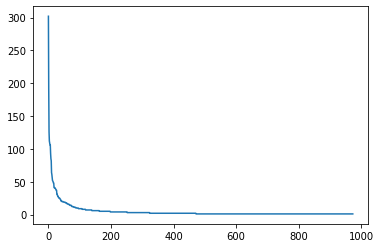

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

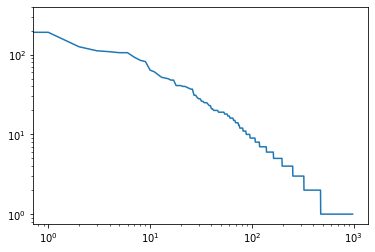

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in a few weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [17]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [18]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [19]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [20]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [21]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [22]:
import nltk

In [23]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [24]:
whText.common_contexts(['stem'])

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [25]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

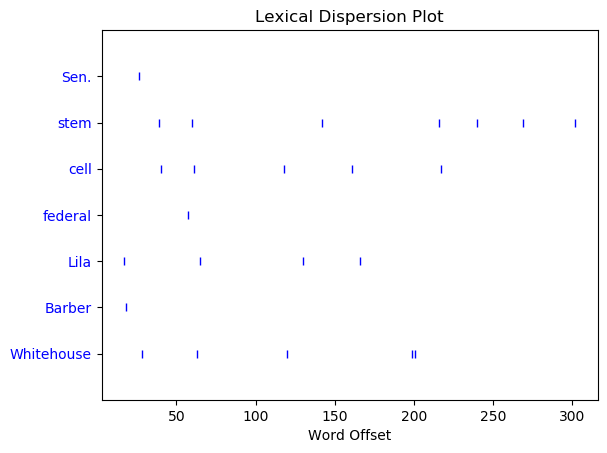

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [27]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [28]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

But before we proceed: what is the lambda function here? What the lambda function does here is that it iterates over the list row by row and applies the function, e.g. word_tokenize() or len(), to each list. So, it looks similar to for loop; but, lambda is an expression while for loop is a statement. I won't elaborate on the difference between these two here for space limitations. 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

### Corpus used here

As my intended project is about speeches, here I want to focus on the speech corpora made by Hillary Clinton and Donald Trump when they were presidential candidates, in order to compare their speech patterns and how they deliver their ideas.

In [31]:
corpus_speech = "/Users/timqzhang/Desktop/UChicago/MACSS_Spring_2020/Corpus_Speeches"

def loadcorpus(corpus_name):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        
        if 'Trump' in file or 'Clinton' in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                if 'txt' in file[6:] and 'SX' not in file:
                    if 'Clinton' in file[6:]:
                        texts_raw[file[8:]] = []
                        with zfile.open(file) as f:
                            for line in f:
                                texts_raw[file[8:]].append(line)
                    elif 'Trump' in file[6:]:
                        texts_raw[file[6:]] = []
                        with zfile.open(file) as f:
                            for line in f:
                                texts_raw[file[6:]].append(line)
    return texts_raw

In [32]:
speech_raw=loadcorpus(corpus_speech)

Trump.zip
Clinton.zip


In [33]:
# clean the non-relevant parts

import re #for regexs

def clean_raw_text2(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            
            if 'TRUMP' in text or 'CLINTON' in text:

                clean_text = text.replace("\\'m", "'m").replace("\\'ll", "'ll").replace("\\'re", "'re").replace("\\'s", "'s").replace("\\'re", "'re").replace(" n\'t", "n't").replace("\\'ve", "'ve").replace("\\'d", "'d")
                clean_text= re.sub(r'\n','',clean_text)
                clean_text= re.sub(r'\<\S+\>','',clean_text)
                clean_text= re.sub(r'\<\D+\>','',clean_text)
                
                clean_texts.append(clean_text[1:])
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [34]:
# create the sum-up corpus for Clinton and Trump respectively

clean_trump=[]
clean_clinton=[]

for key in speech_raw.keys():
    
    if 'Trump' in key:
        clean_trump.extend(clean_raw_text2(speech_raw[key]))
    elif 'Clinton' in key:
        clean_clinton.extend(clean_raw_text2(speech_raw[key]))

In [35]:
# decompose into tokens

nlp = spacy.load("en")

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

trump_token = word_tokenize(''.join(clean_trump))
clinton_token = word_tokenize(''.join(clean_clinton))

In [36]:
# count the words and rank from the most frequent

def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

count_trump=wordCounter(trump_token)
count_trump.sort_values('count', ascending=False, inplace=True)
print(count_trump[:50])
print()
count_clinton=wordCounter(clinton_token)
count_clinton.sort_values('count', ascending=False, inplace=True)
print(count_clinton[:50])

        word  count
57       the   3531
6         to   2994
29       and   2960
44        we   2697
1        you   1949
11         i   1816
23        it   1791
15         a   1718
42        of   1711
24        's   1514
52      that   1377
200     they   1299
93        in   1267
187      're   1169
164    going   1103
60      have    983
404      n't    892
71        is    876
159       do    838
27       our    815
176      are    814
81      will    805
49       for    727
20       she    649
68      this    639
76    people    623
82        be    593
85        so    576
113      but    531
162     know    525
158     what    506
108    great    502
63       all    491
36   hillary    449
206     with    431
91       not    420
112      was    412
51   country    400
26        on    386
351       he    381
284    right    350
2       very    333
74       one    332
102     your    325
207     them    322
127     want    320
61       get    306
190       by    304
201     been    302


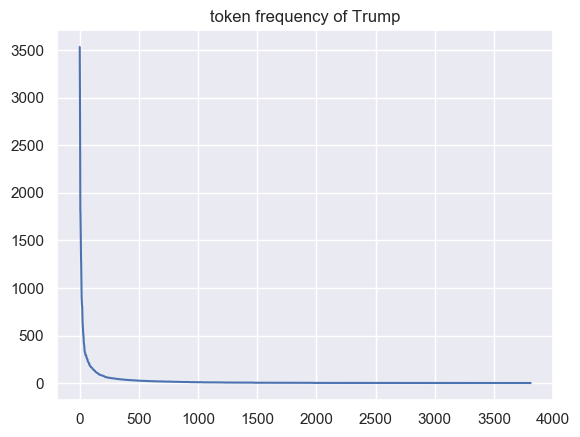

In [37]:
# plot the token frequency from Trump

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_trump)), count_trump['count'])
plt.title('token frequency of Trump')
plt.show()

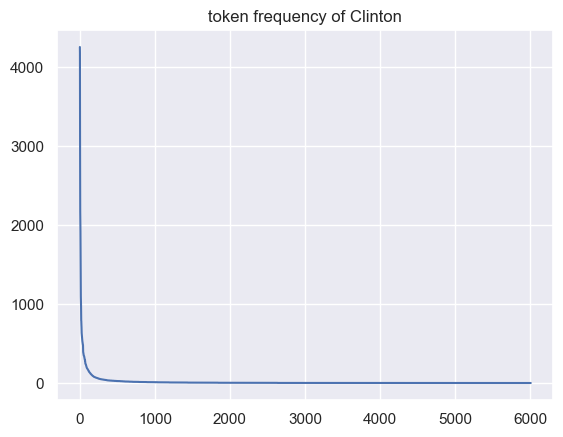

In [38]:
# plot the token frequency from Clinton

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_clinton)), count_clinton['count'])
plt.title('token frequency of Clinton')
plt.show()

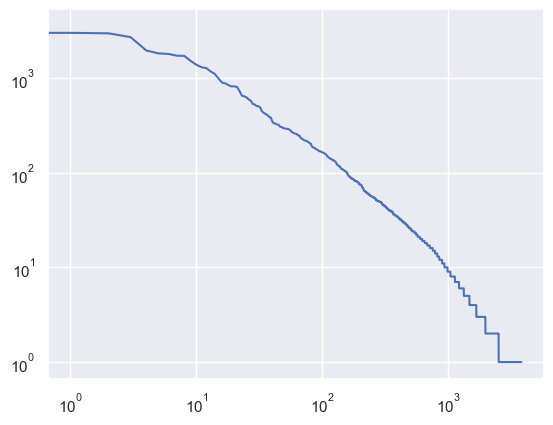

In [39]:
# trump

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_trump)), count_trump['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

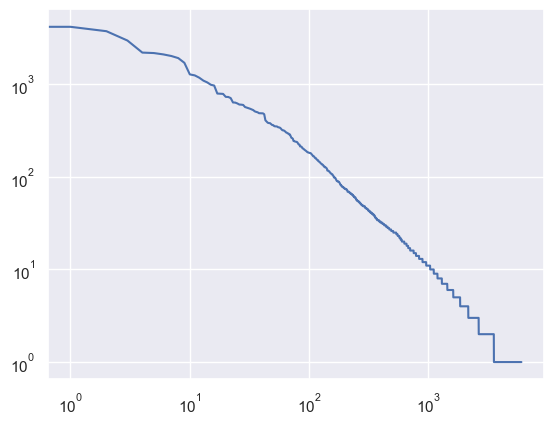

In [40]:
# clinton

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_clinton)), count_clinton['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [41]:
# use nltk

import nltk

trump_Text = nltk.Text(trump_token)
clinton_Text = nltk.Text(clinton_token)

trump_Index = nltk.text.ConcordanceIndex(trump_Text) 
clinton_Index = nltk.text.ConcordanceIndex(clinton_Text) 

# let's see if Trump's slogan "America first" and MAGA are frequently mentioned. It is verified by checking concordance of "America" below.

trump_Index.print_concordance('America')

Displaying 25 of 203 matches:
t very sincerely Now it 's time for America to bind the wounds of division have
 for our future is beyond our reach America will no longer settle for anything 
unity that while we will always put America 's interests first we will deal fai
 All we need is great ideas to make America great again That 's all we need So 
ote But the new adventure is making America great again We 're going to do it A
ion for you to consider Do you want America to be ruled by the corrupt politica
rupt political class?Or do you want America to be ruled by you the people That 
and throughout the United States of America We have to do it We do n't have a c
 A lot of a lot of this up here too America has lost listen to this 70,000 fact
ion will stop the jobs from leaving America and we will stop the jobs from leav
hange From now on it 's going to be America first America first And just in sum
 on it 's going to be America first America first And just in summing up to all
one more t

In [42]:
# check the common words around "America" from Trump

trump_Text.common_contexts(['America'])

for_to reach_will put_'s make_great making_great want_to of_we too_has
leaving_and be_first first_first make_wealthy make_strong make_safe
is_this correct_has support_'s in_justice keep_safe put_first


In [43]:
# for Clinton, "people" is her high frequency word

clinton_Index.print_concordance('people')

Displaying 25 of 615 matches:
 and most of them revolve around the people that I 've had the privilege of meet
ights for LGBT rights and rights for people with disabilities And tomorrow we fa
epublicans independents not just the people who support me in this election ever
k back sending us back in time where people are free to question the foundation 
d making phone calls helping to turn people out maybe helping people who need as
ing to turn people out maybe helping people who need assistance to get to the po
never leaves her face And she brings people together who are on opposite sides o
eed more of that in Washington where people actually talk and listen to each oth
 be clearer And I know that for many people you 've gone back and forth you 've 
presidents over the past decades and people who ran for president I was privileg
 to know a lot of our presidents and people who 've run for president it goes ba
undreds and hundreds of thousands of people hearing what 's on people 's minds 

In [44]:
# check the common words around "people" from Clinton

clinton_Text.common_contexts(['people'])

the_that for_with the_who where_are turn_out helping_who
brings_together where_actually many_you and_who of_hearing on_'s
world_look for_right many_not many_when american_and for_and hard_in
business_and


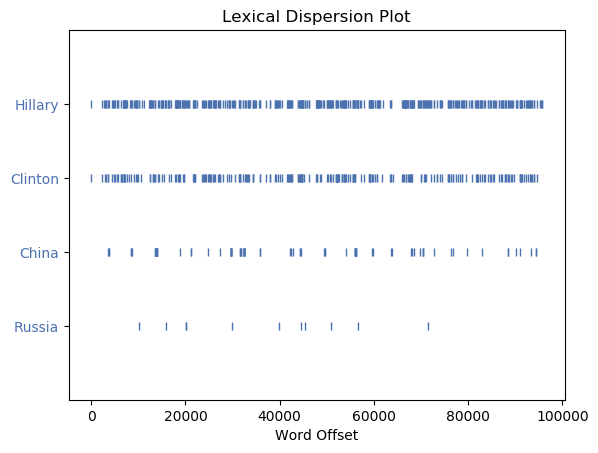

In [45]:
# it is interesting to see that the name of Hillary Clinton is frequently mentioned by Trump, so I put their names in the dispersion plot.

# also, I want to see their attitudes towards U.S.'s potential competitors by checking how frequent they mention China and Russia.

sns.reset_orig() #Seaborn messes with this plot, disabling it
trump_Text.dispersion_plot(['Hillary','Clinton','China','Russia'])
sns.set() #Re-enabling seaborn

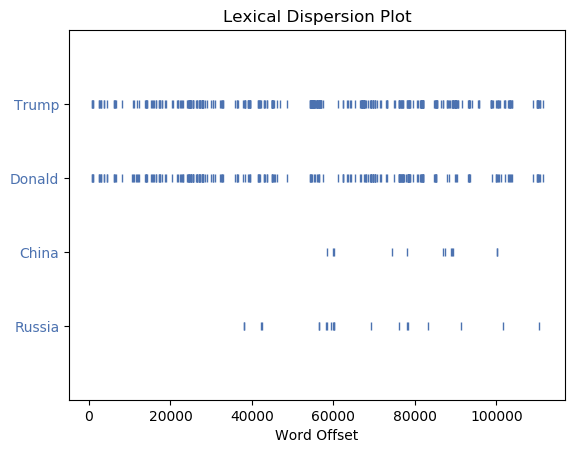

In [46]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
clinton_Text.dispersion_plot(['Trump','Donald','China','Russia'])
sns.set() #Re-enabling seaborn

### Inference/Comment

From the lexical dispersion plots, it is clear that Trump mentions Clinton's name almost throughout the speeches, while Clinton do not, with "gaps" in the plot from time to time. Perhaps it reveals the propaganda strategy for Trump. Also, we can say that Trump mentions China more often in the corpus than Clinton, which also accords to his later-on policies towards China.

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent than the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [47]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

What are we doing here? We want to get the list of all words in the corpus, and then count how many times each word is used. "whReleases['tokenized_text'].sum()" does the the former; and the rest of the codes in the loop does the latter. And then we use sorted function to sort the words in a descending order, i.e., arranged from the largest to the smallest number.

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [48]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

We're already familiar with for and if statements. But what does the break statement do here? Let's go back to what we are up to: We are trying to find words that occur more frequently than Whitehouse, which is the cutoff word that we're using here. So, using "break", we stopped when we see "Whitehouse"; then, we appended the words that appeared before "Whitehouse", i.e., the words that occurred more frequently than Whitehouse. As you can see, what the break statement does is: it stops the execution of the loop and move on to the next line of code. 

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [49]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [50]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  word_counts  \
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350   
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497   
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189   
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236   
5  [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...          334   
6  [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...          241   
7  [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...          469   
8  [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...          443   
9  [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...          425   

                                   normalized_tokens  normalized_tokens_count  
0  [sen, whitehouse, share, westerly, girl, story...                      224  
1  [sen, whitehouse, say, president, bush, begin,...                      159  
2  [epa, review, legal, process, root, political,...                      298  
3  [r.i, senator, praise, sen, denial, lng, facil...                      116  
4  [sen, whitehouse, comment, year, anniversary, ...                      125  
5  [sens, reed, whitehouse, welcome, rhod

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [51]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

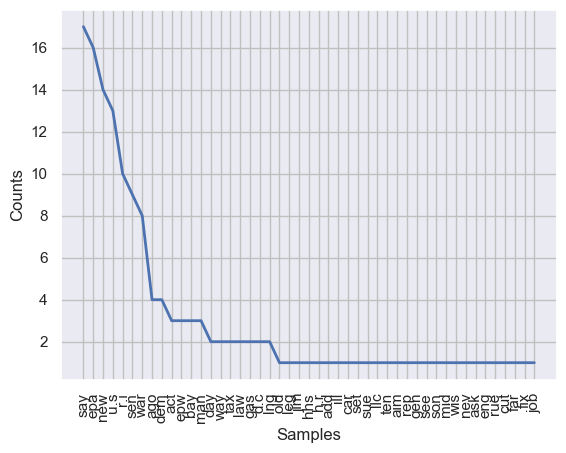

In [52]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [53]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [54]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [55]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [56]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 132, 'NNP': 34})),
 ('whitehouse', FreqDist({'NNP': 17, 'VB': 14, 'NN': 4, 'RB': 4, 'WDT': 1})),
 ('shares', FreqDist({'VBZ': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [57]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [58]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [59]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('stem', 10),
 ('consulate', 10)]

Or plot the base form verbs against their number of occurrences

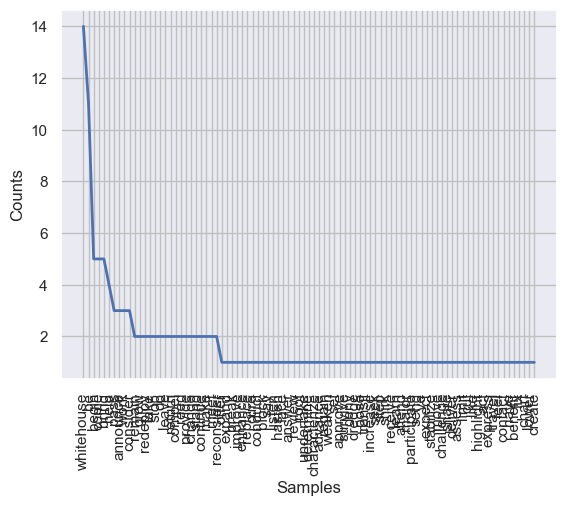

In [60]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [61]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

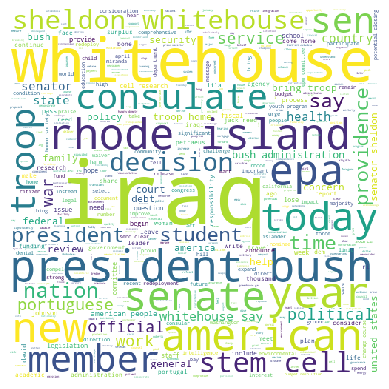

In [62]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

### Corpus used here

I will mainly use the corpus of speeches made by Trump here.

In [63]:
# transfer the corpus into dataframe

clean_trump_dict={'source':[],'text':[]}
clean_clinton_dict={'source':[],'text':[]}

for key,value in speech_raw.items():
    if 'Trump' in key:
        clean_trump_dict['source'].append(key)
        clean_trump_dict['text'].append(''.join(clean_raw_text2(value)))
    else:
        clean_clinton_dict['source'].append(key)
        clean_clinton_dict['text'].append(''.join(clean_raw_text2(value)))
        
trump_df=pandas.DataFrame(clean_trump_dict)
clinton_df=pandas.DataFrame(clean_clinton_dict)

In [64]:
# create the tokenized series

trump_df['tokenized_text'] = trump_df['text'].apply(lambda x: word_tokenize(x))
clinton_df['tokenized_text'] = clinton_df['text'].apply(lambda x: word_tokenize(x))

In [65]:
#count the words for Trump

countsDict = {}

# lower the word letters

for word in [x.lower() for x in trump_df['tokenized_text'].sum()]:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]

[('the', 3531),
 ('to', 2994),
 ('and', 2960),
 ('we', 2697),
 ('you', 1950),
 ('i', 1816),
 ('it', 1791),
 ('a', 1718),
 ('of', 1711),
 ("'s", 1514),
 ('that', 1377),
 ('they', 1299),
 ('in', 1267),
 ("'re", 1169),
 ('going', 1103),
 ('have', 983),
 ("n't", 892),
 ('is', 876),
 ('do', 838),
 ('our', 815),
 ('are', 814),
 ('will', 805),
 ('for', 727),
 ('she', 649),
 ('this', 639),
 ('people', 623),
 ('be', 593),
 ('so', 576),
 ('but', 531),
 ('know', 525),
 ('what', 506),
 ('great', 502),
 ('all', 491),
 ('hillary', 449),
 ('with', 431),
 ('not', 420),
 ('was', 412),
 ('country', 400),
 ('on', 386),
 ('he', 381),
 ('right', 350),
 ('very', 333),
 ('one', 332),
 ('your', 325),
 ('them', 322),
 ('want', 320),
 ('get', 306),
 ('by', 304),
 ('been', 302),
 ('just', 294),
 ('about', 294),
 ('said', 291),
 ('there', 290),
 ('out', 290),
 ('like', 288),
 ("'ve", 283),
 ('back', 278),
 ('now', 269),
 ('thank', 268),
 ('jobs', 262),
 ("'ll", 260),
 ('from', 258),
 ('at', 256),
 ('clinton', 254

In [66]:
# as it may be hard to get a clear cut on stop word, I here will choose "country".

stop_words_freq = []
for word, count in word_counts:
    if word == 'country':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the',
 'to',
 'and',
 'we',
 'you',
 'i',
 'it',
 'a',
 'of',
 "'s",
 'that',
 'they',
 'in',
 "'re",
 'going',
 'have',
 "n't",
 'is',
 'do',
 'our',
 'are',
 'will',
 'for',
 'she',
 'this',
 'people',
 'be',
 'so',
 'but',
 'know',
 'what',
 'great',
 'all',
 'hillary',
 'with',
 'not',
 'was']

In [67]:
#normalize the tokens

def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

trump_df['normalized_tokens'] = trump_df['tokenized_text'].apply(lambda x: normalizeTokens(x,stop_words_freq))

In [68]:
#.sum() adds together the lists from each row into a single list

trump_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in trump_df['normalized_tokens'].sum()))

#print the number of words

print(trump_cfdist.N())

35466


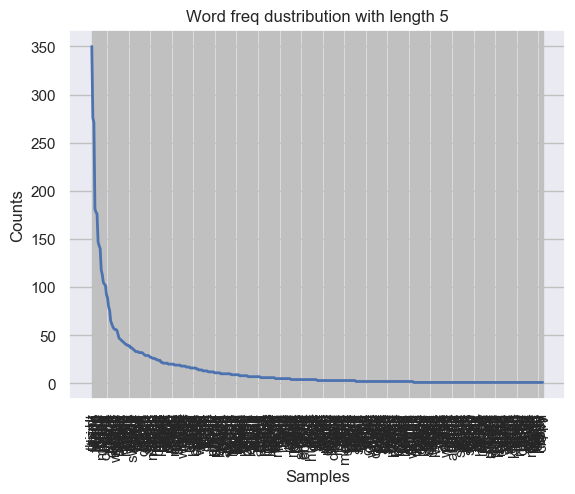

In [69]:
# plot the word freq dustribution with length 5
trump_cfdist[5].plot(title='Word freq dustribution with length 5')

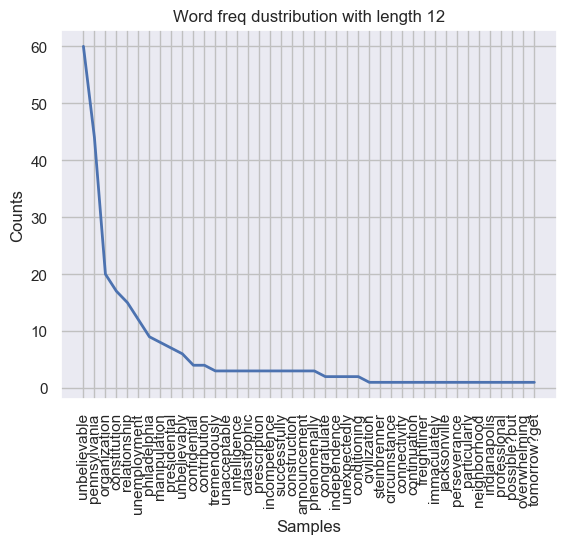

In [70]:
# plot the word freq dustribution with length 14

trump_cfdist[12].plot(title='Word freq dustribution with length 12')

In [71]:
# generate the conditional probability distribution by length

# as there will be error if I don't put the bin number below, I set it to 500.

trump_cpdist = nltk.ConditionalProbDist(trump_cfdist, nltk.ELEProbDist,500)

# report the conditional probability dist given different length of words

for i in range(3,15):
    print ('The most common {} letter word: {}, its prob density = {}.'.format(i,trump_cpdist[i].max(),trump_cpdist[i].prob(trump_cpdist[i].max())))

The most common 3 letter word: say, its prob density = 0.08199958428601123.
The most common 4 letter word: want, its prob density = 0.055717939349652905.
The most common 5 letter word: right, its prob density = 0.05284981905910736.
The most common 6 letter word: happen, its prob density = 0.04864572047670639.
The most common 7 letter word: country, its prob density = 0.09921592279855247.
The most common 8 letter word: american, its prob density = 0.06103023516237402.
The most common 9 letter word: obamacare, its prob density = 0.05514342235410485.
The most common 10 letter word: government, its prob density = 0.0662063363119415.
The most common 11 letter word: immediately, its prob density = 0.056348074179743225.
The most common 12 letter word: unbelievable, its prob density = 0.11862745098039215.
The most common 13 letter word: investigation, its prob density = 0.09709821428571429.
The most common 14 letter word: administration, its prob density = 0.2364341085271318.


### Inference/Comment

It is interesting to see that "obamacare" is the most common word in length 9, indicating that it is quite often mentioned, and it accords with the frequent criticism of obamacare by Trump.

In [72]:
# another feature: word role in the sentence

def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

trump_df['normalized_tokens_POS'] = [spacy_pos(t) for t in trump_df['text']]

trump_cfdist_WordtoPOS = nltk.ConditionalFreqDist(trump_df['normalized_tokens_POS'].sum())
list(trump_cfdist_WordtoPOS.items())[10:20]

[('keep', FreqDist({'VB': 55, 'VBP': 13})),
 ('waiting', FreqDist({'VBG': 26, 'NN': 1})),
 (';', FreqDist({':': 93, ',': 1})),
 ('complicated', FreqDist({'JJ': 3})),
 ('business', FreqDist({'NN': 36})),
 ('i', FreqDist({'PRP': 1813, 'NNP': 1})),
 ("'ve", FreqDist({'VB': 283})),
 ('just', FreqDist({'RB': 294})),
 ('received', FreqDist({'VBD': 10, 'VBN': 5})),
 ('a', FreqDist({'DT': 1713, 'RB': 2}))]

In [73]:
# generate POS to word

trump_cfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in trump_df['normalized_tokens_POS'].sum())

In [74]:
# check the most common adj

trump_cfdist_POStoWord['JJ'].most_common(10)

[('great', 470),
 ('right', 175),
 ('other', 168),
 ('american', 151),
 ('many', 147),
 ('good', 125),
 ('bad', 119),
 ('big', 110),
 ('first', 87),
 ('last', 86)]

[('be', 592), ('have', 315), ('do', 312), ("'ve", 283), ('get', 236), ('make', 166), ('win', 143), ('tell', 135), ('say', 130), ('go', 128)]


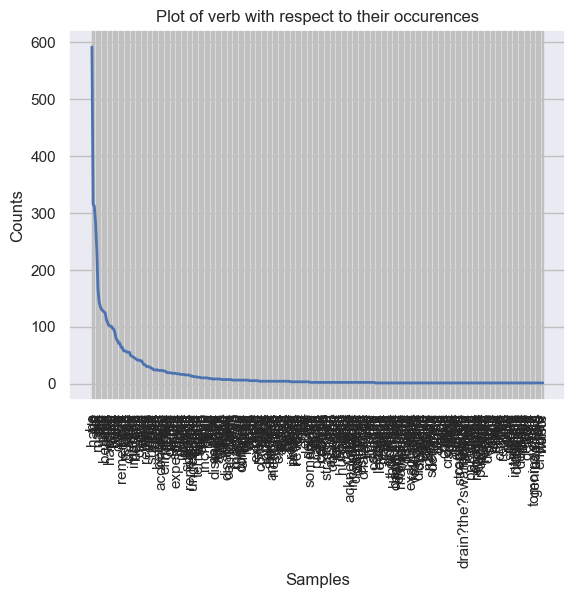

In [75]:
# plot the verb with respect to their occurence

print(trump_cfdist_POStoWord['VB'].most_common(10))
plt.title('Plot of verb with respect to their occurences')
trump_cfdist_POStoWord['VB'].plot()

In [76]:
# conditional word probability dist by the roles

trump_cpdist_POStoWord = nltk.ConditionalProbDist(trump_cfdist_POStoWord, nltk.ELEProbDist,1500)

#print the most common noun
print(trump_cpdist_POStoWord['NN'].max())

#And its probability
print(trump_cpdist_POStoWord['NN'].prob(trump_cpdist_POStoWord['NN'].max()))

country
0.037844254510921174


In [77]:
#print the most common interjection
print(trump_cpdist_POStoWord['UH'].max())

#And its probability
print(trump_cpdist_POStoWord['UH'].prob(trump_cpdist_POStoWord['UH'].max()))

oh
0.06658395368072788


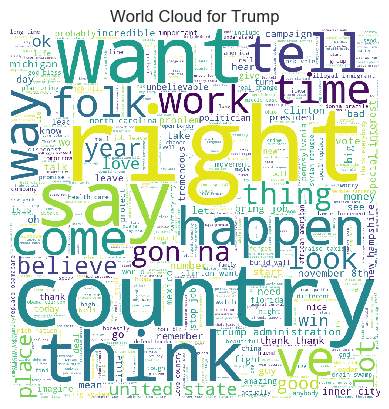

In [78]:
# create the word cloud

trump_wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 2000, height = 2000, mode ='RGBA', scale=.5).generate(' '.join(trump_df['normalized_tokens'].sum()))
plt.imshow(trump_wc)
plt.axis("off")
plt.title('World Cloud for Trump')
plt.savefig("trump_word_cloud.pdf", format = 'pdf')

### Inference/Comment

It is quite interesting to see that in the speeches of Trump, there exists many colloquial words like 'want', 'say', etc., which accords to the media's comment on his speeches that says "Trump's words are usually quite basic".

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [79]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [80]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [81]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [82]:
movie_texts = {}

In [83]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [84]:
import pandas as pd

In [85]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [86]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [87]:
movie_df.head()

Movie Name            Genre  Year          Country  \
6850720    Animal Crackers  Comedy, Musical  1930          English   
176501       Anna Christie   Drama, Romance  1930          English   
4056770  Ladies of Leisure   Drama, Romance  1930          English   
5992934      Over the Hill            Drama  1931          English   
4436137  Design for Living  Comedy, Romance  1933  English, French   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...  
4056770  [Look, out, There, 's, another, bottle, coming...  
5992934  [Good, morning, kitty, Come, in, here, baby, I...  
4436137  [Train_engine_grinding, 26;1426;TOOLONG, Whist...

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [88]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [89]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [90]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [91]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [92]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[Last, year, Help, Desk, got, a, call, from, ...  
8  [[First, post, in, quite, some, time], [I, wor...  
7  [[Original, Post](https://www.reddit.com, r, r...  
6  [[I, witnessed, this, astounding, IT, meltdown...  
5  [[I, work, Helpdesk, for, a, retail, store, ch...  
4  [[This, just, happened], [So, I, had, a, lapto...  
3  [[Another, tale, from, the, out, of, hours], [...  
2  [[Part, 1](http://www.reddit.com, r, talesfrom...  
1  [[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ...  
0  [[So, my, story, starts, on, what, was, a, nor...

In [93]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [94]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [95]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [96]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('m', 21),
 ('password', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('Genius', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [97]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

### Corpus used here

I here would like to use a subset of the corpus of Trump speeches.

In [98]:
# create the subset

trump_df_sub = trump_df[['source','text']][-10:]

In [99]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [100]:
#create series of sentences

trump_df_sub['sentences'] = trump_df_sub['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [101]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [102]:
trump_df_sub['POS_sents'] = trump_df_sub['sentences'].apply(lambda x: tag_sents_pos(x))

In [103]:
trump_df_sub['POS_sents']

10    [[(Thank, VBP), (you, PRP), (very, RB), (much,...
11    [[(Great, JJ), (crowd, NN), (thank, VBP), (you...
12    [[(Thank, VBP), (you, PRP), (Thank, VBP), (you...
13    [[(Thank, VBP), (you, PRP), (very, RB), (much,...
14    [[(Thank, VBP), (you, PRP)], [(Coach, NNP), (B...
15    [[(Wow, UH), (What, WP), (a, DT), (great, JJ),...
16    [[(Wow, UH), (In, IN), (one, CD), (day, NN), (...
17    [[(Thank, VBP), (you, PRP), (very, RB), (much,...
18    [[(In, IN), (one, CD), (day, NN), (we, PRP), (...
19    [[(This, DT), (is, VBZ), (amazing, JJ)], [(Wha...
Name: POS_sents, dtype: object

In [104]:
# see the number of adjectives

countTarget = 'JJ'
targetCounts = {}
for entry in trump_df_sub['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('great', 233),
 ('other', 91),
 ('American', 78),
 ('big', 72),
 ('many', 69),
 ('bad', 60),
 ('good', 53),
 ('safe', 41),
 ('dishonest', 39),
 ('special', 38),
 ('first', 38),
 ('tremendous', 36),
 ('new', 35),
 ('corrupt', 34),
 ('incredible', 33),
 ('inner', 33),
 ('last', 33),
 ('illegal', 32),
 ('political', 31),
 ('criminal', 31)]

In [105]:
# see the number of verbs

countTarget = 'VB'
targetCounts = {}
for entry in trump_df_sub['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 291),
 ('have', 155),
 ('do', 144),
 ('get', 116),
 ('make', 91),
 ('tell', 72),
 ('win', 71),
 ('say', 71),
 ('take', 62),
 ('bring', 57),
 ('know', 56),
 ('want', 52),
 ('go', 51),
 ('stop', 50),
 ('believe', 46),
 ('vote', 43),
 ('happen', 43),
 ('build', 38),
 ('see', 36),
 ('think', 34)]

In [106]:
# see the number of nouns (common noun and proper noun)

countTarget = ['NN','NNP']
targetCounts = {}
for entry in trump_df_sub['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind not in countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('Hillary', 236),
 ('country', 211),
 ('Clinton', 131),
 ('ve', 131),
 ('m', 111),
 ('time', 109),
 ('America', 106),
 ('way', 95),
 ('percent', 87),
 ('Trump', 74),
 ('United', 62),
 ('world', 60),
 ('Obamacare', 59),
 ('lot', 58),
 ('money', 56),
 ('day', 56),
 ('plan', 54),
 ('care', 53),
 ('States', 53),
 ('state', 52)]

In [107]:
# I would like to continue checking attitude on obamacare, by checking what adj or verbs are associated with it.

NTarget = 'JJ'
Word = 'obamacare'
NResults = set()
for entry in trump_df_sub['POS_sents']:
    for sentence in entry:
        #print(sentence)
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add((ent1,ent2))
            else:
                continue

print(NResults)

NTarget = 'VB'
Word = 'obamacare'
NResults = set()
for entry in trump_df_sub['POS_sents']:
    for sentence in entry:
        #print(sentence)
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add((ent1,ent2))
            else:
                continue

print(NResults)

{('crazy', 'Obamacare')}
{('replace', 'Obamacare'), ('terminate', 'Obamacare'), ('be', 'Obamacare'), ('expand', 'Obamacare')}


### Inference/Comment

It is clear that Trump thinks Obamacare is "crazy", and need to "replace","terminate" and "expand" it, showing great negative attitude.

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [108]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [109]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [110]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  9, The second word is: 40
The first word is:  40, The second word is: 4
The first word is:  4, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 12
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 9
The first word is:  9, The second word is: 4


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [111]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [112]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [113]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [114]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [115]:
import gensim

In [116]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [117]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [118]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

### Corpus used here

Still the Trump speech corpus.

In [119]:
# still the trump speech corpus

trump_Bigrams = nltk.collocations.BigramCollocationFinder.from_words(trump_df['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(trump_Bigrams.N))

There are 35466 bigrams in the finder


In [120]:
# check the raw counts

def bigramScoring(count, wordsTuple, total):
    return count

print(trump_Bigrams.nbest(bigramScoring, 10))

[('gon', 'na'), ('united', 'states'), ('trump', 'administration'), ('thank', 'thank'), ('e', 'mail'), ('bring', 'job'), ('new', 'hampshire'), ('inner', 'city'), ('november', '8th'), ('special', 'interest')]


In [121]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

trump_Bigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  276, The second word is: 276
The first word is:  276, The second word is: 14
The first word is:  14, The second word is: 36
The first word is:  36, The second word is: 2
The first word is:  2, The second word is: 48
The first word is:  48, The second word is: 2
The first word is:  2, The second word is: 276
The first word is:  276, The second word is: 283
The first word is:  283, The second word is: 30
The first word is:  30, The second word is: 28


In [122]:
# check the likelihood ratio of 2-gram collocations

bigram_measures = nltk.collocations.BigramAssocMeasures()
trump_Bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('gon', 'na'), 1807.0073366397646),
 (('united', 'states'), 1267.378150632545),
 (('trump', 'administration'), 907.5445491191718),
 (('e', 'mail'), 852.8294376881378),
 (('november', '8th'), 767.7889982943254),
 (('north', 'carolina'), 667.2627856048305),
 (('special', 'interest'), 660.5147594352993),
 (('inner', 'city'), 655.1387112248765),
 (('new', 'hampshire'), 619.0102077647525),
 (('god', 'bless'), 470.53872677774586),
 (('syrian', 'refugee'), 468.1304127741753),
 (('drain', 'swamp'), 464.82166673604115),
 (('donna', 'brazile'), 461.53156444570965),
 (('illegal', 'immigrant'), 453.3352465483049),
 (('law', 'enforcement'), 438.2301566719167),
 (('rich', 'nation'), 408.9179773466785),
 (('health', 'care'), 406.95917784676783),
 (('sanctuary', 'city'), 365.9881383104513),
 (('thank', 'thank'), 364.88182224286606),
 (('repeal', 'replace'), 361.54842485826373),
 (('middle', 'east'), 361.12065377523135),
 (('bernie', 'sander'), 354.0942059946549),
 (('rig', 'system'), 353.90036749662

### Inference/Comment

For the 2-gram phrases with high likelihood ratio, many of them are proper phrases indicating certain place, name or conception, like 'united states', 'health care', etc. Morevoer, some phrases are combined by verb+noun, indicating Trump's policies, like 'build wall' and 'replace obamacare'.

In [123]:
# check 3-gram phrases by student-t values

trigram_measures = nltk.collocations.TrigramAssocMeasures()
trump_Trigrams = nltk.collocations.TrigramCollocationFinder.from_words(trump_df['normalized_tokens'].sum())
trump_Trigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('plan', 'bring', 'job'), 5.476457444942902),
 (('stop', 'job', 'leave'), 5.195086236639631),
 (('repeal', 'replace', 'obamacare'), 4.795790894539378),
 (('african', 'american', 'community'), 4.472051517039146),
 (('donor', 'special', 'interest'), 4.358869601700984),
 (('thank', 'thank', 'thank'), 4.3550642909313515),
 (('trans', 'pacific', 'partnership'), 4.242639341306256),
 (('medal', 'honor', 'recipient'), 4.24263671376653),
 (('restore', 'honesty', 'government'), 4.2426323390309415),
 (('world', 'trade', 'organization'), 4.242596613710116),
 (('great', 'job', 'theft'), 4.242517058583148),
 (('trump', 'administration', 'stop'), 4.2423105562972685),
 (('day', 'trump', 'administration'), 4.242190508725625),
 (('m', 'ask', 'vote'), 4.241976381665005),
 (('clinton', 'want', 'double'), 4.241574092815623),
 (('cut', 'ronald', 'reagan'), 4.123102189572846),
 (('honor', 'endorsement', 'admiral'), 4.12309572703199),
 (('woman', 'law', 'enforcement'), 4.123094861464922),
 (('endorsement', 

### Inference/Comment

Many of the 3-grams are expansion of 2-grams, adding one more noun or verb. However, we can still see some 3-gram irreducable phrases like 'world trade organization', 'african american community', etc.

In [124]:
# check 4-gram phrases

Ngrams = nltk.ngrams(trump_df['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 3:
        pass
    else:
        Filtered[key] = Counts[key]

# find the most common 4-grams 

sorted(Filtered.items(),key=lambda x: x[1])[-20:]

[(('admiral', 'general', 'medal', 'honor'), 16),
 (('general', 'medal', 'honor', 'recipient'), 16),
 (('think', 'accomplish', 'day', 'trump'), 16),
 (('man', 'woman', 'law', 'enforcement'), 16),
 (('believe', 'government', 'serve', 'donor'), 16),
 (('government', 'serve', 'donor', 'special'), 16),
 (('serve', 'donor', 'special', 'interest'), 16),
 (('ve', 'wait', 'entire', 'life'), 16),
 (('america', 'strong', 'america', 'safe'), 16),
 (('big', 'tax', 'cut', 'ronald'), 16),
 (('clinton', 'want', 'double', 'obamacare'), 17),
 (('want', 'entire', 'corrupt', 'washington'), 17),
 (('china', 'enter', 'world', 'trade'), 17),
 (('enter', 'world', 'trade', 'organization'), 17),
 (('great', 'job', 'theft', 'history'), 17),
 (('job', 'theft', 'history', 'world'), 17),
 (('trump', 'administration', 'secure', 'defend'), 17),
 (('honor', 'endorsement', 'admiral', 'general'), 17),
 (('accomplish', 'day', 'trump', 'administration'), 17),
 (('tax', 'cut', 'ronald', 'reagan'), 17)]

### Inference/Comment

4-grams are mostly verb+noun, indicating the opinions of Trump, like 'clinton want double obamacare','china enter world trade', etc., which may show his view on them.

In [125]:
# I will pick "trump administration" and check if it is idiomatic and irreducible via student-t value.

# pick the first 20 highest-t_value bigrams with 'trump' in them

# implement the conditional frequency

i=0
for grams in trump_Bigrams.score_ngrams(bigram_measures.student_t):
    if 'trump' == grams[0][0]:
        print(grams)
        i+=1
    if i>=20:
        break

(('trump', 'administration'), 9.1705629226904)
(('trump', 'rally'), 1.9603000056392037)
(('trump', 'hat'), 1.7119951054417242)
(('trump', 'shirt'), 1.3966684778571032)
(('trump', 'say'), 1.361664899443367)
(('trump', 'thank'), 1.3151750972762646)
(('trump', 'hispanic'), 1.2984160045675497)
(('trump', 'woman'), 1.2212176326971862)
(('trump', 'lead'), 1.1826184467620044)
(('trump', 'debate'), 1.0176946523116823)
(('trump', 'inexperienced'), 0.9950375007049005)
(('trump', 'rally?and'), 0.9950375007049005)
(('trump', 'regalia'), 0.9950375007049005)
(('trump', 'retire'), 0.9950375007049005)
(('trump', 'right?so'), 0.9950375007049005)
(('trump', 'trump!thank'), 0.9950375007049005)
(('trump', 'disturbing'), 0.990075001409801)
(('trump', 'ho'), 0.9851125021147014)
(('trump', 'hold'), 0.9801500028196019)
(('trump', 'lewd'), 0.9801500028196019)


### Inference/Comment

From the t-values, we can verify that 'trump administration' is significantly occured.

In [126]:
# then we use t-test to find what words come after 'america' more ofhen than 'china'

# for america

i=0
for grams in trump_Trigrams.score_ngrams(trigram_measures.student_t):
    if 'america' == grams[0][0]:
        for gram_china in trump_Trigrams.score_ngrams(trigram_measures.student_t):
            if gram_china[0]==('china',grams[0][1],grams[0][2]):
                print(grams)
                print (gram_china)
                print()
        i+=1
    if i>=20:
        break

(('america', 'stop', 'job'), 3.603827976321919)
(('china', 'stop', 'job'), 1.4122873182848374)



### Inference/Comment

From above, the 2-gram 'stop job' comes more frequently after 'america' than 'china' by comparing the t values.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [127]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [128]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [129]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [130]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [131]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [132]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [133]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('today', 6),
 ('Boss', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [134]:
[x[0] for x in sortedEntities if x[1] == 2]

['two',
 'first',
 '1',
 '3',
 '5',
 '10',
 'second',
 'each day',
 'Edit 2',
 '30k',
 'Caller',
 'XYZ',
 'last week',
 'three',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [135]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('today', 6),
 ('Boss', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [136]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

### Corpus used here

I will still use the corpus of Trump created before.

In [137]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [138]:
trump_df_sub['classified_sents'] = trump_df_sub['sentences'].apply(lambda x: tag_sents_ner(x))

In [139]:
trump_df_sub['classified_sents']

10    [[], [], [], [(thousands, CARDINAL)], [], [(al...
11    [[], [], [(five days, DATE), (Florida, GPE)], ...
12    [[], [(First, ORDINAL)], [(Mike Pence, PERSON)...
13    [[], [(Mike Pence, PERSON)], [], [], [], [], [...
14    [[], [], [], [], [], [], [], [], [], [(two, CA...
15    [[], [(Hillary Clinton, PERSON), (650,000, CAR...
16    [[(one day, DATE), (Florida, GPE)], [(the Whit...
17    [[], [], [], [(about 3,000, CARDINAL)], [(4,00...
18    [[(one day, DATE), (Pennsylvania, GPE)], [(the...
19    [[], [], [(thousands, CARDINAL)], [], [], [], ...
Name: classified_sents, dtype: object

In [140]:
# entity counts

entityCounts = {}

for entry in trump_df_sub['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Hillary', 128),
 ('America', 99),
 ('Hillary Clinton', 89),
 ('one', 81),
 ('American', 65),
 ('Trump', 62),
 ('Florida', 47),
 ('Michigan', 47),
 ('Mexico', 39),
 ('Mosul', 38)]

In [141]:
# non obj counts

nonObjCounts = {}
for entry in trump_df_sub['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Hillary', 128),
 ('America', 99),
 ('Hillary Clinton', 89),
 ('one', 81),
 ('American', 65),
 ('Trump', 62),
 ('Florida', 47),
 ('Michigan', 47),
 ('Mexico', 39),
 ('Mosul', 38)]

In [142]:
# name of person counts

PerCounts = {}
for entry in trump_df_sub['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'PERSON':
                if ent in PerCounts:
                    PerCounts[ent] += 1
                else:
                    PerCounts[ent] = 1
sortedPer = sorted(PerCounts.items(), key = lambda x: x[1], reverse = True)
sortedPer[:10]

[('Hillary', 128),
 ('Hillary Clinton', 89),
 ('Trump', 50),
 ('Obamacare', 19),
 ('Donna Brazile', 18),
 ('Clinton', 14),
 ('Donald Trump', 14),
 ('Bill', 13),
 ('Bill Clinton', 12),
 ('Bernie Sanders', 10)]

In [143]:
# check all the types

trump_ner_types = []
for sent in trump_df_sub['classified_sents']:
    for sentence in sent:
        for ent, kind in sentence:
            if kind not in trump_ner_types:
                trump_ner_types.append(kind)
trump_ner_types

['CARDINAL',
 'GPE',
 'DATE',
 'PERSON',
 'FAC',
 'TIME',
 'PERCENT',
 'ORG',
 'NORP',
 'LAW',
 'ORDINAL',
 'EVENT',
 'LOC',
 'QUANTITY',
 'MONEY',
 'PRODUCT',
 'WORK_OF_ART']

In [144]:
# build a dict to link types and their entitles

trump_type_entitle = {}

for types in trump_ner_types:
    trump_type_entitle[types] = []
    
for sent in trump_df_sub['classified_sents']:
    for sentence in sent:
        for ent, types in sentence:
            trump_type_entitle[types].append(ent)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

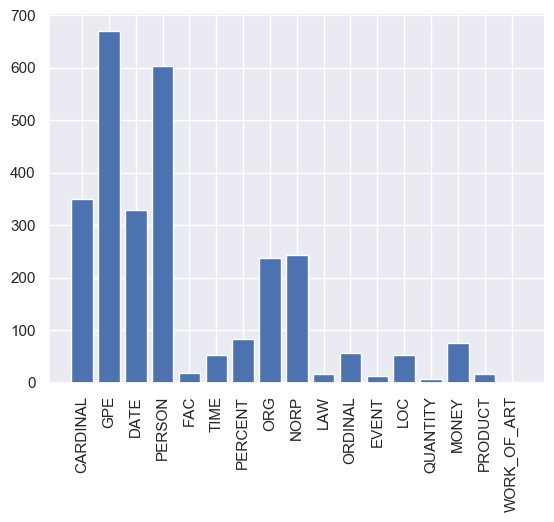

In [145]:
# plot the frequency by types

type_count = []
for types in trump_ner_types: 
    type_count.append(len(trump_type_entitle[types]))
    
plt.bar(trump_ner_types, type_count)
plt.xticks(rotation=90)

### Inference/Comment

The two most frequent types are 'PERSON' and 'GPE', which indicates that in the speeches of Trump during the election, he mostly mentioned the geograpic places and many people. It makes sense, as it shows close relation to mention the place between Trump and the people at that place, which is good for the support rate. Also, as we have noticed that Trump liked to mention persons' names and make comments on them, it makes sense for such a high frequency of 'person' type. 

In [146]:
# check the precision, recall, and F-measures of PERSON, and we take the subset of corpus, namely one speech from Trump.

trump_df_class_sub2=trump_df_sub['classified_sents'][10]

person_name=[]

for sent in trump_df_class_sub2: 
    for ent in sent: 
        if ent[1] == 'PERSON': 
            person_name.append(ent[0])

print(person_name)

['Reince Priebus', 'Ron Johnson', 'Ron', 'Sean Duffy', 'Brad Courtney', 'Brad', 'Scott Walker', 'Walker', 'Scott', 'Giuliani', 'Bobby Knight', 'Obamacare', 'Obamacare', 'Hillary Clinton', 'Hillary Clinton', "Hillary Clinton 's", 'Obamacare', 'Hillary', 'Hillary', 'Hillary', 'Hillary', 'Hillary', 'Hillary', 'Bernie Sanders', 'Donna Brazile Donna Brazile', 'Donna Brazile', 'Donna Brazile', 'Hillary Hillary', 'Bernie Sanders', 'Hillary', 'John Podesta', 'WikiLeaks', 'John Podesta', 'Amazing Nasty', 'Hillary', 'Bernie Sanders', 'Clinton', 'Hillary Clinton', 'Donald Trump', 'Clintons', 'Bill', 'Hillary', 'Bill', 'Hillary', 'Scott', 'Trump', 'Donald Trump', 'Hillary', 'Trump', 'Hillary Clinton', 'Trump', 'Hillary', 'Hillary', 'Hillary Clinton', 'Hillary', 'Casey Chadwick', 'Casey', 'Hillary', 'Kate Steinle', 'Trump', 'Clinton', 'Fort McCoy', 'Hillary', 'Obama', 'Hillary Clinton', 'Hillary', 'Hillary', 'Ronald Reagan', 'Hillary', 'Hillary Clinton']


In [147]:
# then we could generate the dummy list to indicate whether elements in person_name should be considered as person.

# 1 for this element is indeed person, 0 for not.

true_type_person_dummy=[1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                  0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,
                  1,1,1,1,1,1,1,1]

print(len(true_type_person_dummy),len(person_name))

predict_type_person_dummy = [int(x) for x in list(np.zeros(70)+1)]

print(sklearn.metrics.classification_report(true_type_person_dummy, predict_type_person_dummy)) 

70 70
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.91      1.00      0.96        64

    accuracy                           0.91        70
   macro avg       0.46      0.50      0.48        70
weighted avg       0.84      0.91      0.87        70



/Users/timqzhang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Inference/Comment
We will just focus on the prediction on 1, the precision is quite high. 

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [148]:
from spacy import displacy

In [149]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [150]:
displacy.render(doc, style='dep')

In [151]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [152]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [153]:
from spacy.symbols import nsubj, VERB

In [154]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [155]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [156]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [157]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [158]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [159]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [160]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [161]:
movie_violences = {}

In [162]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [163]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I', 'I'], ['them', 'you', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': ([], ['shalt', 'Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': ([], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'],
  ['story', 'him', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': ([], []),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'you', 'intrusion']),
 'Charlie Chan at the Race Track': (['shoe', 'you'], []),
 'The Prisoner of Shark Island': (['government'], ['what', 'husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Cousin Gus": ([],

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Exercise 7*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

### Corpus used here

I still pick a subset of Trump speeches.

In [164]:
sent_list=[x.strip() for x in trump_df_sub['text'][10].split('.') if x.strip()!='']

# pick 5 sentences as example.

for sent in sent_list[20:25]: 
    doc = nlp(sent)
    displacy.render(doc, style='dep')

### Inference/Comment

From the parsing, we can see that the phrase structure and dependency parse trees are quite deeply nested, especially if the sentences are complicated in grammar and structure. As mentioned above, the parse depth are closely perceived sentence complexity.

In [165]:
# find the noun chunks from sentence 20-49, as the speech is quite long.

for sent in sent_list[20:50]: 
    doc = nlp(sent)
    print()
    for chunk in doc.noun_chunks:
        print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)


He He nsubj is
he he nsubj is

I I nsubj want
he he nsubj is
one tough cookie cookie attr is

Governor Walker Walker pobj to
I I nsubj want
you you dobj thank

Tremendous, tremendous competitor competitor ROOT competitor

we we nsubj 're
him him pobj with

you you dobj Thank

you you dobj Thank

I I nsubj want
you you pobj of
attendance attendance pobj in
everyone everyone conj want
who who nsubj is
part part attr is
this magnificent movement movement pobj of
America America nsubj great

what what dobj do
we we nsubj going

we we nsubj going
the great state state dobj win
Wisconsin Wisconsin pobj of

we we nsubj going
the White House House dobj win

It It nsubj going
folks folks dobj happen

A lot lot ROOT lot
good polls polls pobj of

We We nsubj got
we we nsubj 're
North Carolina Carolina pobj in


We We nsubj 're
Florida Florida pobj in
Ohio Ohio pobj in

We We nsubj doing
we we nsubj doing

Iowa Iowa ROOT Iowa
Iowa Iowa pobj in

We We nsubj getting
tremendous help help dobj gettin

In [166]:
# find the tokens' children from sentence 20-49, as the speech is quite long.

for sent in sent_list[20:50]: 
    doc = nlp(sent)
    print()
    for token in doc:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])


He nsubj is AUX []
is ccomp is AUX [He, tough]
tough acomp is AUX []
, punct is AUX []
he nsubj is AUX []
is ROOT is AUX [is, ,, he, brutal]
brutal acomp is AUX []

I nsubj want VERB []
want ccomp is AUX [I, be]
to aux be AUX []
be xcomp want VERB [to, respectful]
very advmod respectful ADJ []
respectful acomp be AUX [very]
, punct is AUX []
he nsubj is AUX []
is ROOT is AUX [want, ,, he, cookie]
one nummod cookie NOUN []
tough amod cookie NOUN []
cookie attr is AUX [one, tough]

So advmod want VERB []
, punct want VERB []
to prep want VERB [Walker]
Governor compound Walker PROPN []
Walker pobj to ADP [Governor]
, punct want VERB []
I nsubj want VERB []
want ROOT want VERB [So, ,, to, ,, I, thank]
to aux thank VERB []
thank xcomp want VERB [to, you]
you dobj thank VERB []

Tremendous amod competitor NOUN []
, punct competitor NOUN []
tremendous amod competitor NOUN []
competitor ROOT competitor NOUN [Tremendous, ,, tremendous]

and cc 're AUX []
we nsubj 're AUX []
're ROOT 're AUX [a

In [167]:
# find the verbs that associate with nominal subject

from spacy.symbols import nsubj, VERB

verb_subj = []
for sent in sent_list[20:50]:
    doc=nlp(sent)
    for possible_word1 in doc:
        if possible_word1.pos == VERB:
            for possible_word2 in possible_word1.children:
                if possible_word2.dep == nsubj:
                    verb_subj.append(possible_word1)
                    break
verb_subj

[want,
 want,
 want,
 going,
 going,
 going,
 going,
 got,
 doing,
 doing,
 getting,
 know,
 saying,
 going,
 looks,
 love,
 love,
 said,
 looks,
 want,
 respect]

In [168]:
# find the adjectives that associate with adverb modifier

from spacy.symbols import ADJ, advmod

adj_advm = []
for sent in sent_list[20:50]:
    doc=nlp(sent)
    for possible_word1 in doc:
        if possible_word1.pos == ADJ:
            for possible_word2 in possible_word1.children:
                if possible_word2.dep == advmod:
                    adj_advm.append(possible_word1)
                    break
adj_advm

[respectful, great, loyal]

In [169]:
# find the adjectives that associate with nominal subj

from spacy.symbols import ADJ, nsubj

adj_subj = []
for sent in sent_list[20:50]:
    doc=nlp(sent)
    for possible_word1 in doc:
        if possible_word1.pos == ADJ:
            for possible_word2 in possible_word1.children:
                if possible_word2.dep == nsubj:
                    adj_subj.append(possible_word1)
                    break
adj_subj

[great]

In [170]:
# find the verbs that associate with direct objects

from spacy.symbols import nsubj, dobj

verb_dobj = []
for sent in sent_list[20:50]:
    doc=nlp(sent)
    for possible_word1 in doc:
        if possible_word1.pos == VERB:
            for possible_word2 in possible_word1.children:
                if possible_word2.dep == dobj:
                    verb_dobj.append(possible_word1)
                    break

verb_dobj

[thank, Thank, Thank, thank, win, win, happen, got, getting, love, love, thank]

In [171]:
# find the adverbs that associate with adverb modifier

from spacy.symbols import advmod,ADV

adv_advm = []
for sent in sent_list[20:50]:
    doc=nlp(sent)
    for possible_word1 in doc:
        if possible_word1.pos == ADV:
            for possible_word2 in possible_word1.children:
                if possible_word2.dep == advmod:
                    adv_advm.append(possible_word1)
                    break

adv_advm

[importantly, there, ahead, of, everywhere, up, up, well]

In [172]:
# capture the word association with the focal set, here i pick 'love' and 'hate' showing Trump's attitude.

# extract the infomation by iterating the tree, find word "love"

love_around = {}

for index, row in trump_df.iterrows():
    text = ' '.join(row['tokenized_text'])
    love_around [row['source']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'love':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                love_around [row['source']][0].append(subject)
            if object_ is not 0:
                love_around [row['source']][1].append(object_)

In [173]:
love_around

{'Trump_2016-11-09.txt': (['who', 'I', 'I'], ['country', 'you', 'country']),
 'Trump_2016-11-08.txt': (['I', 'I', 'I', 'I', 'We'],
  ['Michigan', 'it', 'it', 'you']),
 'Trump_2016-11-02-A.txt': (['I', 'I', 'I', 'I', 'I'],
  ['sign', 'Cubans', 'country']),
 'Trump_2016-11-02-B.txt': (['who',
   'I',
   'I',
   'Clinton',
   'I',
   'I',
   'they',
   'they',
   'They'],
  ['country',
   'you',
   'country',
   'Angels',
   'area',
   'country',
   'country',
   'country']),
 'Trump_2016-11-02-C.txt': (['I', 'we', 'I'], ['you', 'guy']),
 'Trump_2016-11-06.txt': (['I'], ['country']),
 'Trump_2016-11-04-A.txt': (['I', 'We', 'we', 'They', 'We', 'I'],
  ['kind', 'you', 'you', 'country', 'people', 'country']),
 'Trump_2016-11-04-B.txt': (['I'], ['you', 'people']),
 'Trump_2016-11-04-C.txt': (['I', 'I', 'we', 'I', 'I', 'we', 'I'],
  ['Ohio', 'Ohio', 'them', 'them', 'it']),
 'Trump_2016-11-03-B.txt': (['we', 'I'], ['it', 'country']),
 'Trump_2016-11-01-A.txt': (['We', 'We', 'I', 'I', 'I'],
  ['

### Inference/Comment

It is quite interesting to focus on the 'love' word. We can see that Trump expressed his love to the country many times, as well as some states in US.

In [174]:
# extract the infomation by iterating the tree, find word "hate"

hate_around = {}

for index, row in trump_df.iterrows():
    text = ' '.join(row['tokenized_text'])
    hate_around [row['source']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'hate':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                hate_around [row['source']][0].append(subject)
            if object_ is not 0:
                hate_around [row['source']][1].append(object_)

In [175]:
hate_around

{'Trump_2016-11-09.txt': ([], []),
 'Trump_2016-11-08.txt': ([], []),
 'Trump_2016-11-02-A.txt': ([], []),
 'Trump_2016-11-02-B.txt': (['residents'], []),
 'Trump_2016-11-02-C.txt': ([], []),
 'Trump_2016-11-06.txt': ([], []),
 'Trump_2016-11-04-A.txt': ([], []),
 'Trump_2016-11-04-B.txt': ([], []),
 'Trump_2016-11-04-C.txt': ([], []),
 'Trump_2016-11-03-B.txt': ([], []),
 'Trump_2016-11-01-A.txt': (['I'], ['it']),
 'Trump_2016-11-03-A.txt': ([], []),
 'Trump_2016-11-07-D.txt': ([], []),
 'Trump_2016-11-01-B.txt': ([], []),
 'Trump_2016-10-31.txt': ([], []),
 'Trump_2016-11-05-B.txt': ([], []),
 'Trump_2016-11-07-A.txt': (['They', 'they', 'they'], ['Clintons', 'them']),
 'Trump_2016-11-05-A.txt': (['I', 'they'], ['us']),
 'Trump_2016-11-07-C.txt': ([], []),
 'Trump_2016-11-07-B.txt': ([], [])}

### Inference/Comment

The analysis on word "hate" has no very-valuable inferences, the only one interesting may be "they hate Clinton".

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [176]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

name                                               text  \
0  01Apr2005Kennedy14.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
1  01Aug2005Kennedy12.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
2  01Aug2006Kennedy10.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
3  01Aug2006Kennedy11.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
4  01Aug2006Kennedy12.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [177]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [178]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

252

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [179]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

0.9999999999999999

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [180]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6297319091638247
0.5739551553127011


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [181]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0      letter                0.001189
1  bipartisan                0.000385
2   recognize                0.000058
3        bush                0.048938
4      follow                0.001886
5      change                0.001508
6    continue                0.000234
7      family                0.000085
8      agency                0.000098
9    thousand                0.003873

In [182]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
60         iraq                0.096255
3          bush                0.048938
131    american                0.026340
223        stem                0.024093
93          law                0.022779
185  department                0.019514
105      member                0.013502
19          war                0.012874
201     program                0.011162
123     country                0.010368

Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [183]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [184]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [185]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [186]:
len(corpora)

11

In [187]:
fileids = list(movie_df['Movie Name'])[0:11]
fileids

['Animal Crackers',
 'Anna Christie',
 'Ladies of Leisure',
 'Over the Hill',
 'Design for Living',
 'Lady for a Day',
 'Lady Killer',
 'The Mind Reader',
 'Here Is My Heart',
 'Peculiar Penguins',
 'Sadie McKee']

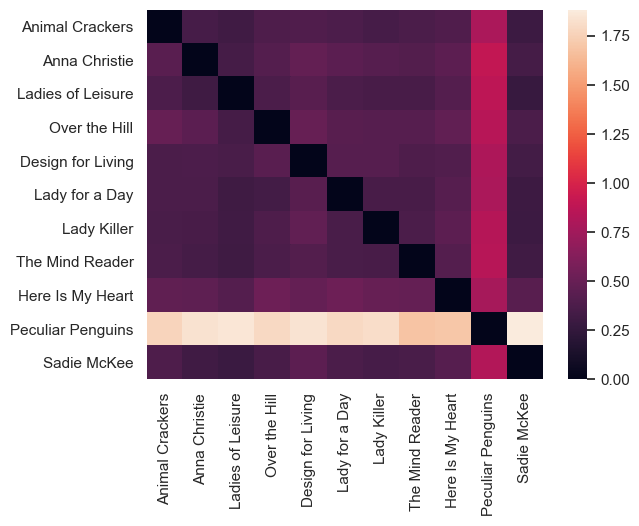

In [188]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/timqzhang/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


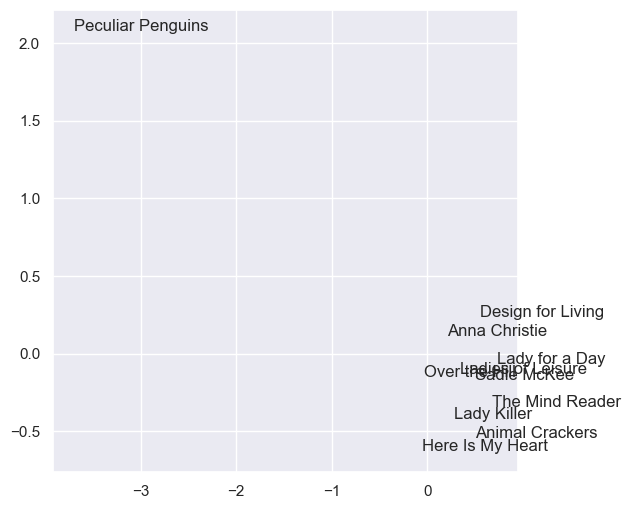

In [189]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

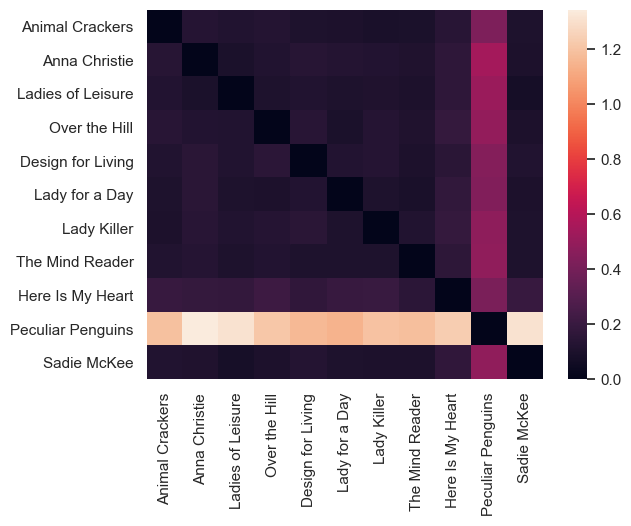

In [190]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

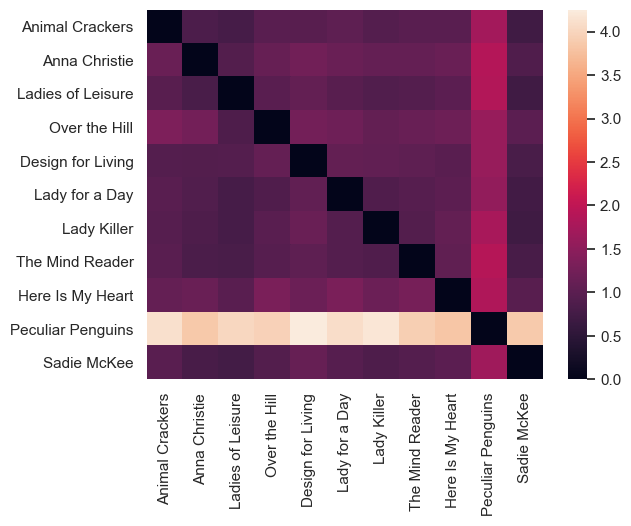

In [191]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

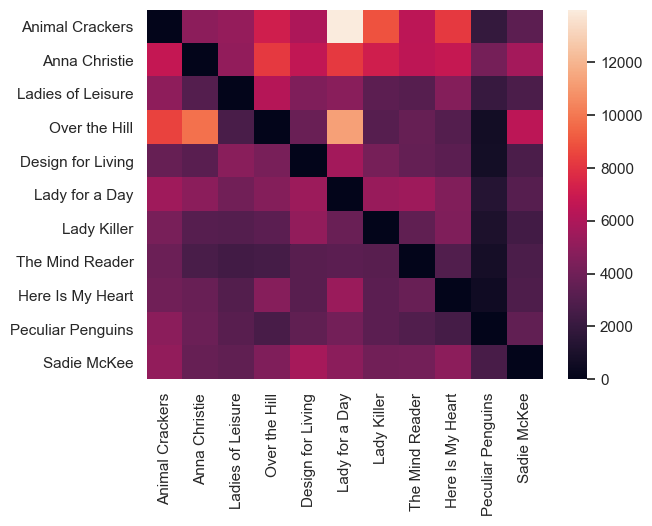

In [192]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

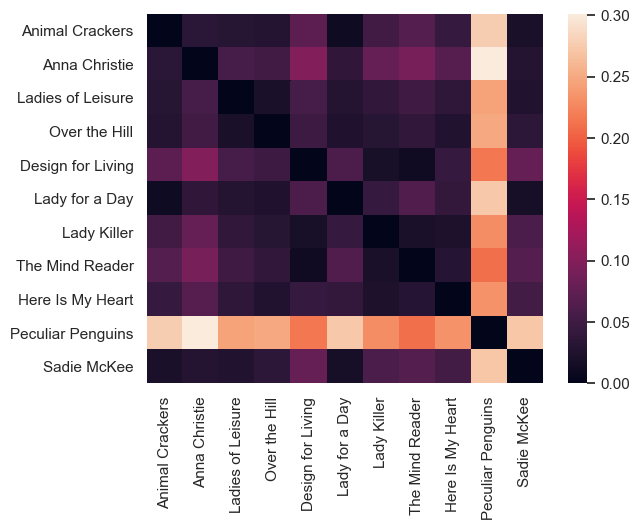

In [193]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

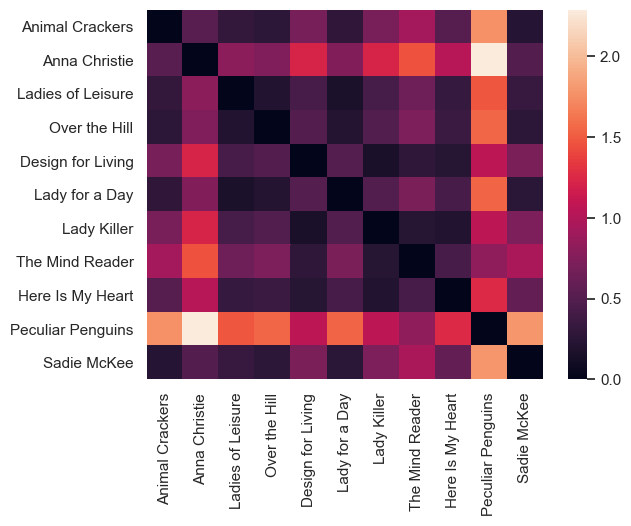

In [194]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

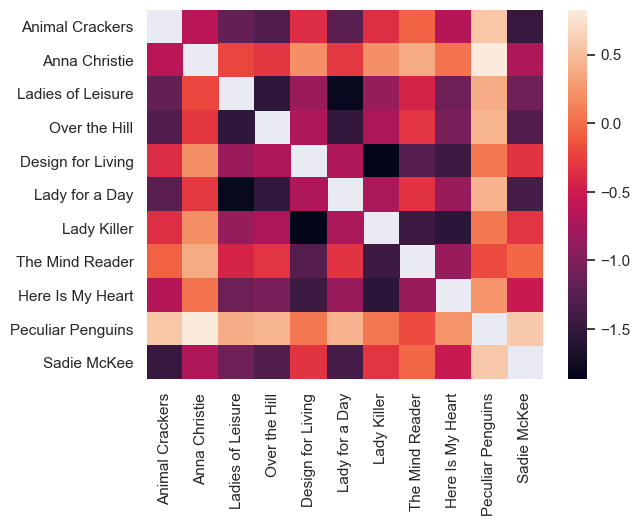

In [195]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [196]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [197]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

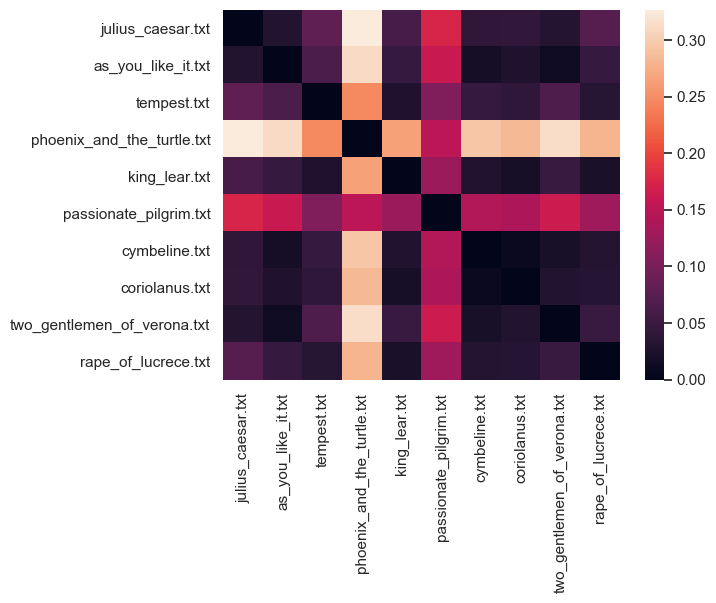

In [198]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 8*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

### Corpus used here

I will pick the speech corpora respectively from Trump and Clinton, and to include more words, I will enlarge the requirement of 4 corpora, which will pick 5 speeches respectively by the two presidential candidates, so 10 corpora in total. Therefore, the comparisons are made in two dimentions. The first one is the pair between speech by two people, and the second one is time-series alike, comparing the corpus between different speeches made by just one person.

In [199]:
# as we have normalized the tokens for Trump, here we do Clinton

#count the words for Clinton

countsDict = {}

# lower the word letters

for word in [x.lower() for x in clinton_df['tokenized_text'].sum()]:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_clinton = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts_clinton[:100]

[('to', 4252),
 ('and', 4173),
 ('the', 3741),
 ('i', 2967),
 ('we', 2198),
 ('of', 2173),
 ('that', 2101),
 ('you', 2022),
 ('a', 1916),
 ('in', 1705),
 ('it', 1278),
 ('for', 1247),
 ("'s", 1177),
 ('is', 1094),
 ('he', 1047),
 ('our', 988),
 ('have', 968),
 ('do', 794),
 ('what', 791),
 ('so', 787),
 ('this', 731),
 ('be', 729),
 ('are', 709),
 ('people', 636),
 ('on', 634),
 ('not', 621),
 ("n't", 604),
 ('who', 602),
 ('know', 598),
 ('about', 568),
 ('with', 560),
 ('they', 553),
 ('all', 544),
 ('going', 534),
 ('but', 526),
 ('as', 510),
 ('can', 503),
 ('was', 498),
 ('want', 487),
 ('my', 486),
 ("'re", 486),
 ('will', 485),
 ('because', 475),
 ("'ve", 408),
 ('america', 396),
 ('if', 384),
 ('get', 381),
 ('just', 380),
 ('your', 371),
 ('out', 363),
 ('make', 362),
 ('here', 353),
 ('at', 351),
 ('trump', 351),
 ('when', 349),
 ('more', 343),
 ('up', 342),
 ('his', 339),
 ('now', 332),
 ('work', 323),
 ('president', 318),
 ('from', 318),
 ('country', 314),
 ('has', 309),
 (

In [200]:
# as it may be hard to get a clear cut on stop word, I here will choose "america".

stop_words_freq_clinton = []
for word, count in word_counts:
    if word == 'america':
        break
    else:
        stop_words_freq_clinton.append(word)
stop_words_freq_clinton

['the',
 'to',
 'and',
 'we',
 'you',
 'i',
 'it',
 'a',
 'of',
 "'s",
 'that',
 'they',
 'in',
 "'re",
 'going',
 'have',
 "n't",
 'is',
 'do',
 'our',
 'are',
 'will',
 'for',
 'she',
 'this',
 'people',
 'be',
 'so',
 'but',
 'know',
 'what',
 'great',
 'all',
 'hillary',
 'with',
 'not',
 'was',
 'country',
 'on',
 'he',
 'right',
 'very',
 'one',
 'your',
 'them',
 'want',
 'get',
 'by',
 'been',
 'just',
 'about',
 'said',
 'there',
 'out',
 'like',
 "'ve",
 'back',
 'now',
 'thank',
 'jobs',
 "'ll",
 'from',
 'at',
 'clinton',
 'say',
 'because',
 'who',
 "'m",
 'has',
 'think',
 'up',
 'never',
 'did',
 'me',
 'their',
 'her',
 'if',
 'time',
 'can',
 'win']

In [201]:
clinton_df['normalized_tokens']=clinton_df['tokenized_text'].apply(lambda x: normalizeTokens(x,stop_words_freq_clinton))

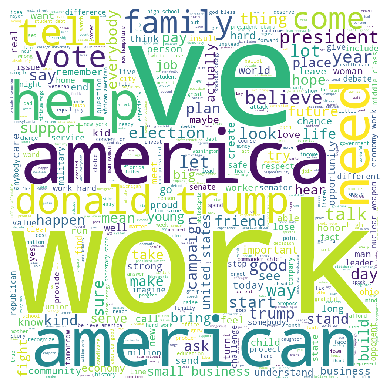

In [202]:
clinton_wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 2000, height = 2000, mode ='RGBA', scale=.5).generate(' '.join(clinton_df['normalized_tokens'].sum()))
plt.imshow(clinton_wc)
plt.axis("off")
plt.savefig("clinton_word_cloud.pdf", format = 'pdf')

In [203]:
# create the subset for this exercise, by selecting the lastest five speeches in the corpora repsectively.

clinton_df_exer8=clinton_df.sort_values('source')[-5:]
trump_df_exer8=trump_df.sort_values('source')[-5:]

In [204]:
# def some funcs to calc the distances

def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [205]:
# combine the two dataframe

df_exer8=trump_df_exer8.append(clinton_df_exer8)

# create the corpora

corpora = []
for index, row in df_exer8.iterrows():
    corpora.append(row['tokenized_text'])

In [206]:
# set the stop/nonstop words

corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [207]:
len(corpora)

10

In [208]:
# set the file ids

fileids = list(df_exer8['source'])
fileids

['Trump_2016-11-07-B.txt',
 'Trump_2016-11-07-C.txt',
 'Trump_2016-11-07-D.txt',
 'Trump_2016-11-08.txt',
 'Trump_2016-11-09.txt',
 'Clinton_2016-11-07-A.txt',
 'Clinton_2016-11-07-B.txt',
 'Clinton_2016-11-07-C.txt',
 'Clinton_2016-11-08.txt',
 'Clinton_2016-11-09.txt']

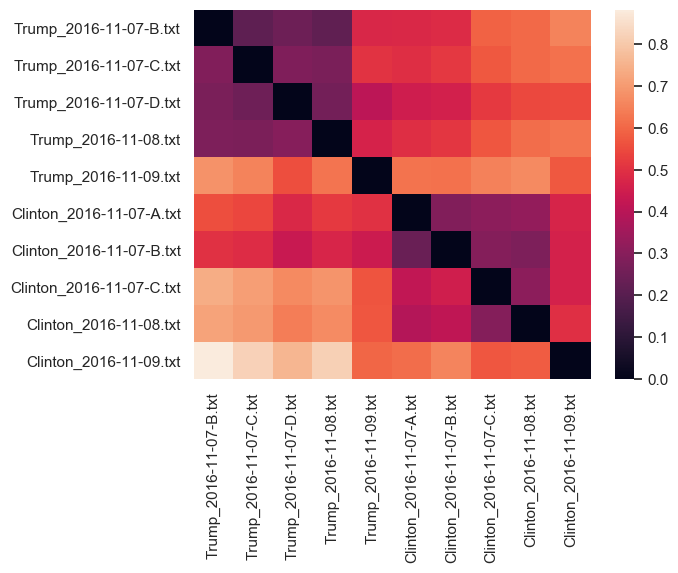

In [209]:
# calculate the KL divergence for each pair in the corpora

L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

/Users/timqzhang/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


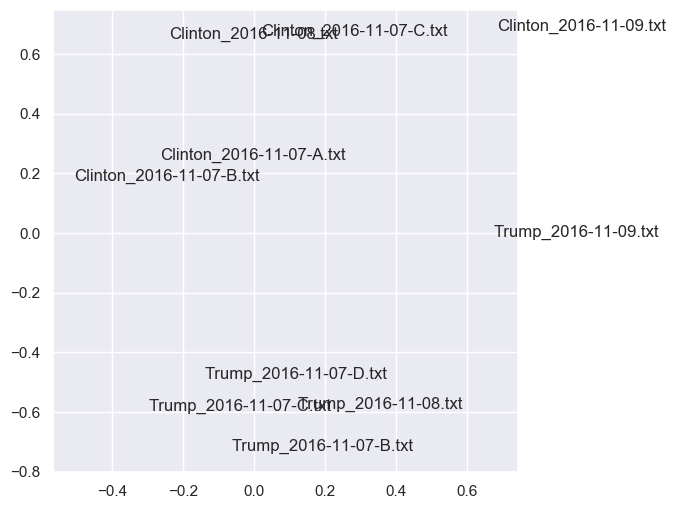

In [210]:
# multidimensional scaling of the matrix to reveal more patterns

mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

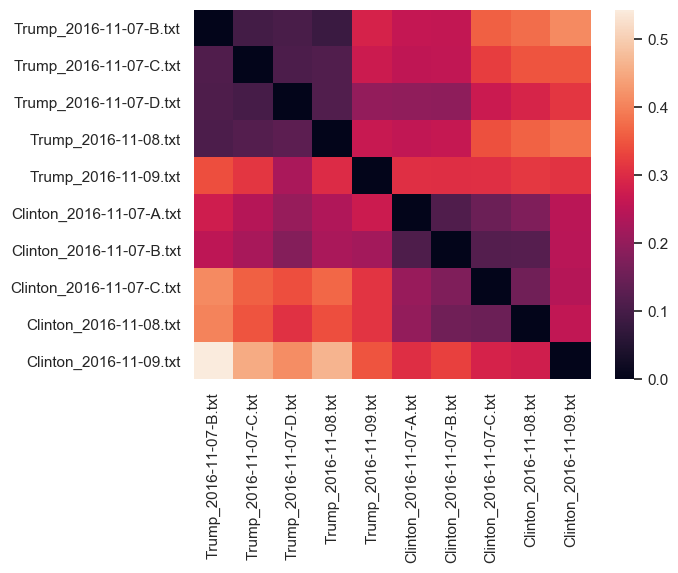

In [211]:
# calculate the KL divergence again for each pair on stop-words

L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

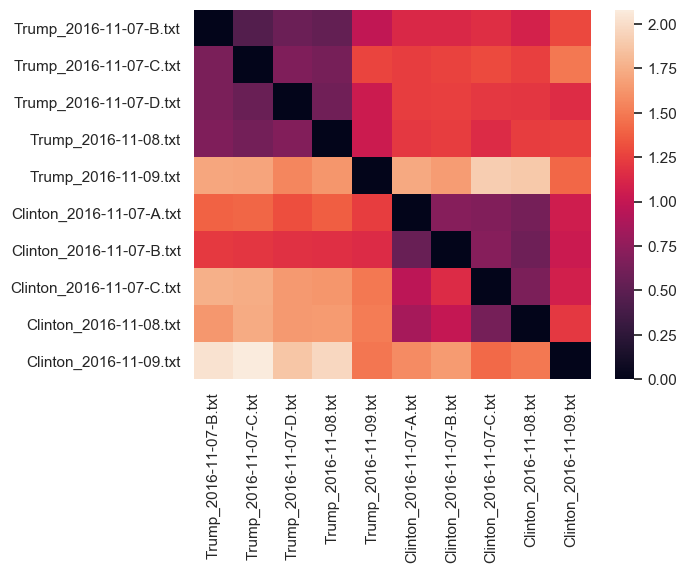

In [212]:
# calculate the KL divergence again for each pair on nonstop-words

L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

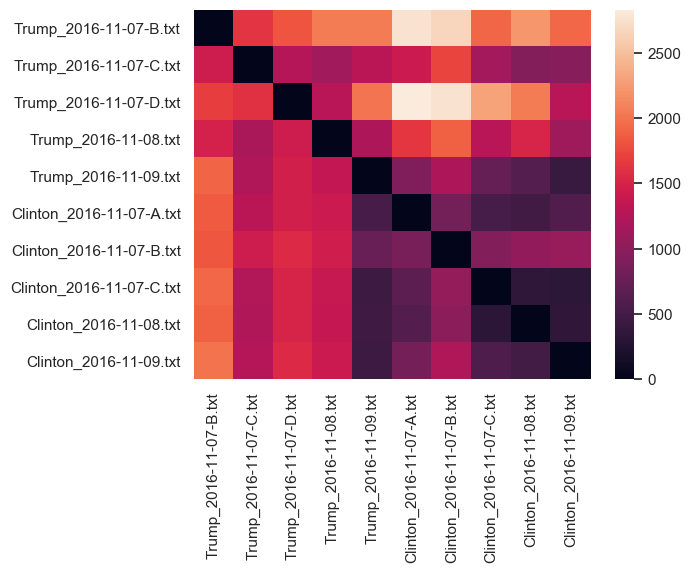

In [213]:
# calculate the Chi2 divergence for each pair on nonstop-words

L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

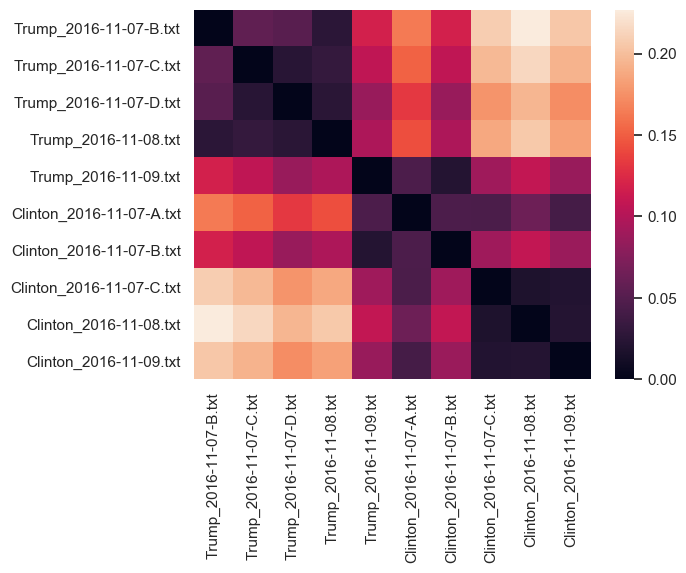

In [214]:
# calculate the KS distance for each pair on nonstop-words

L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

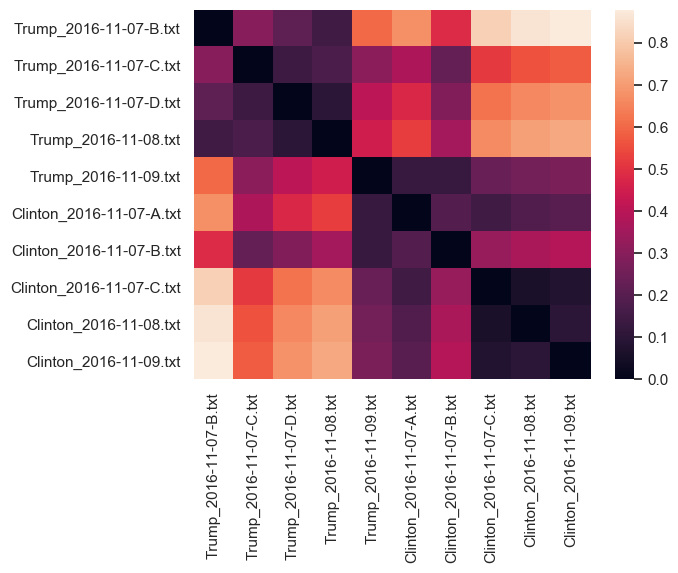

In [215]:
# calculate the Wasserstein distance for each pair on nonstop-words

L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

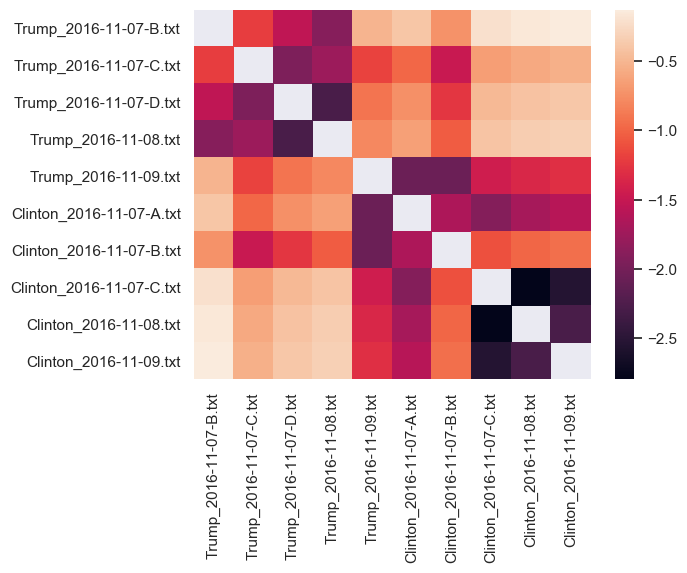

In [216]:
# taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier

ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

### Inference from the charts above

For the heatmap from the Chi2 divergence, as the upper-right and lower-left sections in the chart are the pairs between speeches of Clinton and Trump, and they are lighter, we can say that the speeches made by two people are different and can be distinguished, but the differences in the heatmap is not that clear.

All the other charts other than the Chi2 heatmap show very consistent and clear result on the divergence, which I'm quite happy to see. We can make mainly two conclusions from these charts. 

The first one is similar to the inferences from Chi2 heatmap, but much clearer. These charts verify that the corpus from Trump and that from Clinton are quite different and can be clearly distinguished, as the upper-right and lower-left sections in the charts are the pairs between speeches of two people and they are clearly lighter. The chart of multidimensional scaling also verifies this inference, as the speeches of two people are clustered respectively. It makes sense that due to the different speaking style and content, their speeches could be easily identified and distinguished.

The second inference is for the speeches made by each individual. For Trump, the speeches made by him are not that different, as we can see the upper-left section in the chart is quite darker. The same for the speeches made by Clinton. It also makes sense that the style and pattern of speeches for one person should be consistent at least in a short period. The speeches are all made in three days here.

One notice from the second inference is that, there seems to have two outliners, namely the speech made by Clinton and Trump on 2016-11-09. The outliner of Trump speech could be seen from heatmaps of all the divergence/distance other than the Chi2 one, as it is always the upper-left 4*4 matrix are darker. The outliner for Clinton's 11-09 speech can only be seen from KL heatmaps. Actually the multidimensional scaling chart also shows these two outliners. 

The reason of why these two speeches are quite different from others is also clear when we know that the two speeches on 2016-11-09 are the ones that two candidates made address on their election results. Therefore, the content and pattern should be quite different from others (one win and one lose) and also their previous speeches. 

In [217]:
# def a func on the JS divergence based on its definition.

def js_divergence (X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    m=(p+q)/2
    D_js = scipy.stats.entropy(p, m)/2 + scipy.stats.entropy(q, m)/2
    return D_js


### Inference/Comment

The JS divergence is defined as JSD(P||Q)=1/2*KL(P||M)+1/2*KL(Q||M), where M=1/2*(P+Q). 
It is actually the average KL divergences, which are respectively calculated by each prob distribution (P,Q) and the average of both distributions (M), and that is the relationship.

In [218]:
# add the js_divergence to the Divergence func

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, Wass or JS"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "JS":
        return js_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

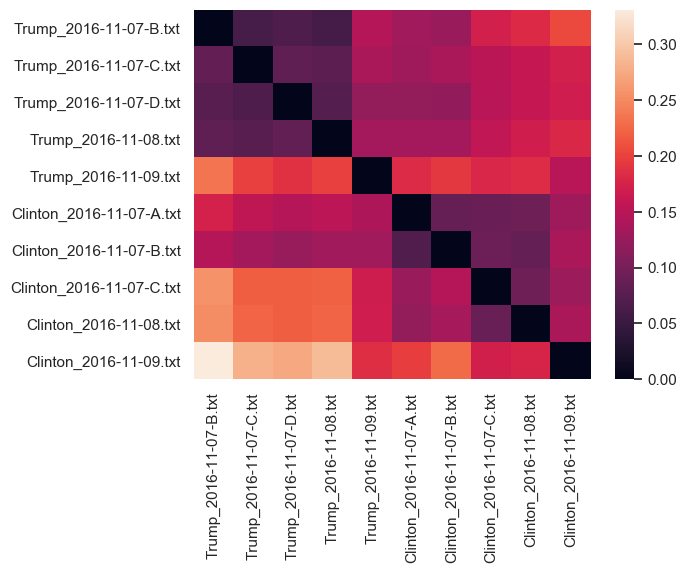

In [219]:
# calculate the JS divergence for each pair in the corpora

L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'JS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

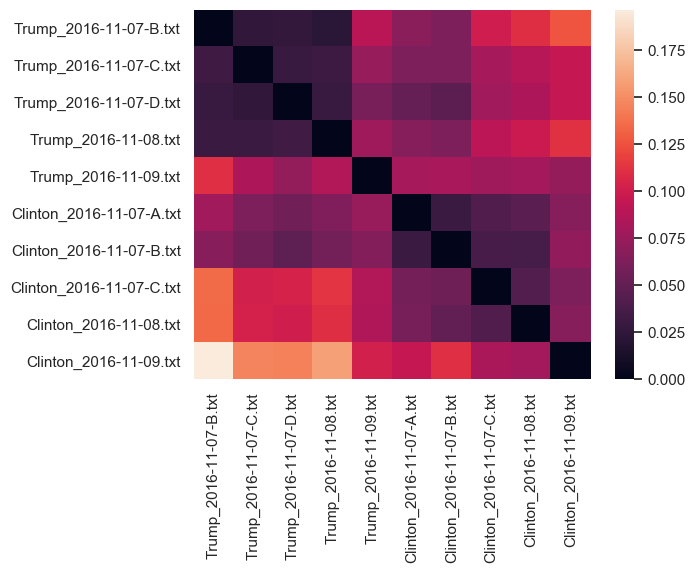

In [220]:
# calculate the JS divergence for each pair on the stop-word

L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference = 'JS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

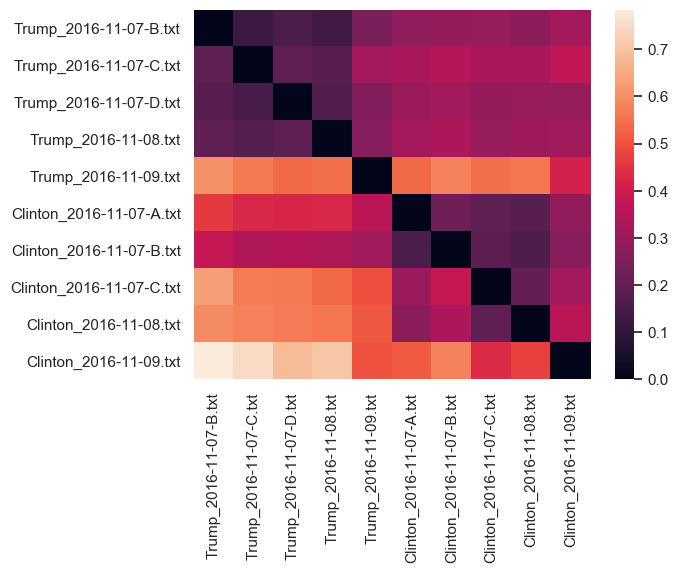

In [221]:
# calculate the JS divergence for each pair on the nonstop-word

L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference = 'JS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### Inference/Comment

The result heatmaps are similar to the KL heatmaps.